## Modules

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
import catboost as ctb

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import eli5
from eli5.sklearn import PermutationImportance

from optuna.integration import LightGBMPruningCallback

from tqdm import tqdm

## Data

In [3]:
df_train = pd.read_hdf("Data/train_power_plant.h5")
df_test = pd.read_hdf("Data/test_power_plant.h5")

df_train.info() # Checking null values


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18366 entries, 0 to 18365
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      18366 non-null  int64  
 1   AT      18366 non-null  float64
 2   AP      18366 non-null  float64
 3   AH      18366 non-null  float64
 4   AFDP    18366 non-null  float64
 5   GTEP    18366 non-null  float64
 6   TIT     18366 non-null  float64
 7   TAT     18366 non-null  float64
 8   TEY     18366 non-null  float64
 9   CDP     18366 non-null  float64
 10  NOX     18366 non-null  float64
 11  CO      18366 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.8 MB


In [4]:
df_train.describe() # checking value range and basic stat

,id,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,NOX,CO
count,18366.000000,18366.000000,18366.000000,18366.000000,18366.000000,18366.000000,18366.000000,18366.000000,18366.000000,18366.000000,18366.000000,18366.000000
mean,18362.830012,17.632490,1013.116327,77.950121,3.924472,25.549357,1081.395268,546.160648,133.505393,12.058930,65.413108,2.377507
std,10603.455265,7.437241,6.445225,14.435682,0.769289,4.187444,17.533809,6.841522,15.607735,1.088456,11.646213,2.265829
min,0.000000,-5.979300,986.160000,24.666000,2.087400,17.698000,1001.300000,511.040000,100.020000,9.851800,27.183000,0.000388
25%,9194.750000,11.662250,1008.900000,68.383250,3.358425,23.103250,1071.900000,544.780000,124.527500,11.427250,57.309750,1.180100
50%,18362.500000,17.684500,1012.600000,80.524500,3.938850,25.099000,1085.800000,549.880000,133.740000,11.964000,63.965000,1.715350
75%,27471.750000,23.605000,1017.000000,89.372500,4.376900,28.922750,1096.775000,550.040000,143.700000,12.816500,71.603750,2.848700
max,36732.000000,37.098000,1036.500000,100.190000,7.554900,40.716000,1100.900000,550.610000,178.310000,15.081000,119.890000,43.428000


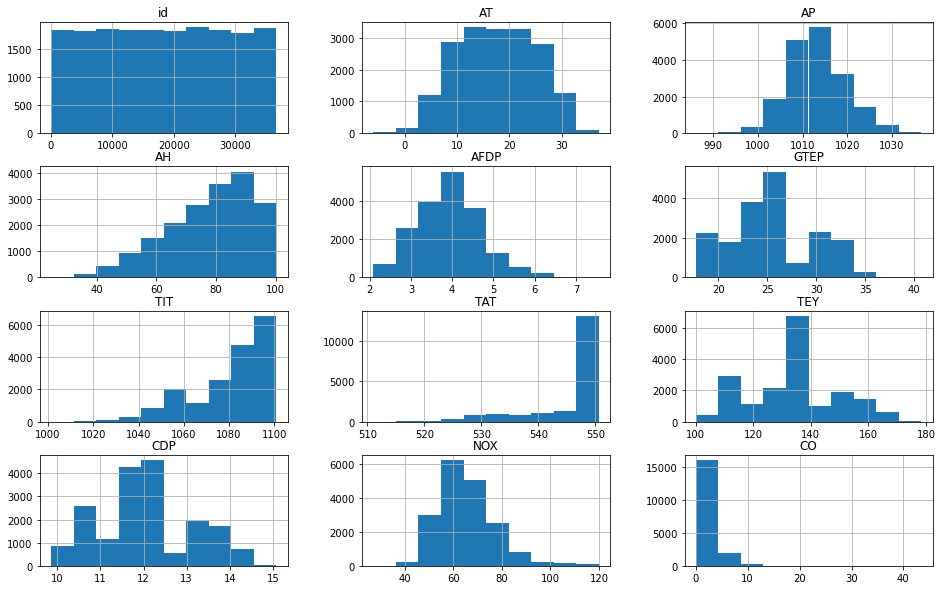

In [5]:
fig = df_train.hist(figsize=(16,10), bins = 10) # checking distribution of feats

## Feats engineering

In [6]:
col_list = df_train.columns.tolist() # new feats from basic calculations {-, / ,*}
df_1 = pd.DataFrame()
df_2 = pd.DataFrame()
new_col_list = []
for i in range (0,len(col_list)):
    for j in range (0,len(col_list)):
        if (col_list[i] in ['CO','id'] or col_list[j] in ['CO','id']) or (col_list[i] == col_list[j]):
            pass
        elif (col_list[j] + '-' + col_list[i] in new_col_list) or (col_list[j] + '/' + col_list[i] in new_col_list) or (col_list[j] + '*' + col_list[i] in new_col_list):
            pass
        else:
            df_1[col_list[i] + '-' + col_list[j]] = df_train[col_list[i]] - df_train[col_list[j]]
            df_1[col_list[i] + '/' + col_list[j]] = df_train[col_list[i]]/df_train[col_list[j]]
            df_1[col_list[i] + '*' + col_list[j]] = df_train[col_list[i]]*df_train[col_list[j]]
            new_col_list.append(col_list[i] + '-' + col_list[j])
            new_col_list.append(col_list[i] + '/' + col_list[j])
            new_col_list.append(col_list[i] + '*' + col_list[j] )

        if (col_list[i] == 'CO' or col_list[j] == 'CO') or (col_list[i] == col_list[j]):
            pass
        elif col_list[j] + '-' + col_list[i] in new_col_list:
            pass
        else:
            df_2[col_list[i] + '-' + col_list[j]] = df_test[col_list[i]] - df_test[col_list[j]]
            df_2[col_list[i] + '/' + col_list[j]] = df_test[col_list[i]]/df_test[col_list[j]]
            df_2[col_list[i] + '*' + col_list[j]] = df_test[col_list[i]]*df_test[col_list[j]]

In [7]:
temp_list = ['AT', 'TIT', 'TAT'] # New feats with mix values
bar_list = ['AP', 'AFDP', 'GTEP', 'CDP']

In [8]:

df_1['feat_mix1_1'] = df_1['AT-TIT']/ df_1['AP-AFDP']
df_1['feat_mix1_2'] = df_1['AT-TIT']/ df_1['AFDP-GTEP']
df_1['feat_mix1_3'] = df_1['AT-TIT']/ df_1['AFDP-CDP']
df_1['feat_mix1_4'] = df_1['AT-TIT']/ df_1['AP-GTEP']
df_1['feat_mix1_5'] = df_1['AT-TIT']/ df_1['AP-CDP']

df_1['feat_mix2_1'] = df_1['TIT-TAT']/ df_1['AP-AFDP']
df_1['feat_mix2_2'] = df_1['TIT-TAT']/ df_1['AFDP-GTEP']
df_1['feat_mix2_3'] = df_1['TIT-TAT']/ df_1['AFDP-CDP']
df_1['feat_mix2_4'] = df_1['TIT-TAT']/ df_1['AP-GTEP']
df_1['feat_mix2_5'] = df_1['TIT-TAT']/ df_1['AP-CDP']

df_1['feat_mix3_1'] = df_1['AT-TAT']/ df_1['AP-AFDP']
df_1['feat_mix3_2'] = df_1['AT-TAT']/ df_1['AFDP-GTEP']
df_1['feat_mix3_3'] = df_1['AT-TAT']/ df_1['AFDP-CDP']
df_1['feat_mix3_4'] = df_1['AT-TAT']/ df_1['AP-GTEP']
df_1['feat_mix3_5'] = df_1['AT-TAT']/ df_1['AP-CDP']

df_2['feat_mix1_1'] = df_2['AT-TIT']/ df_2['AP-AFDP']
df_2['feat_mix1_2'] = df_2['AT-TIT']/ df_2['AFDP-GTEP']
df_2['feat_mix1_3'] = df_2['AT-TIT']/ df_2['AFDP-CDP']
df_2['feat_mix1_4'] = df_2['AT-TIT']/ df_2['AP-GTEP']
df_2['feat_mix1_5'] = df_2['AT-TIT']/ df_2['AP-CDP']

df_2['feat_mix2_1'] = df_2['TIT-TAT']/ df_2['AP-AFDP']
df_2['feat_mix2_2'] = df_2['TIT-TAT']/ df_2['AFDP-GTEP']
df_2['feat_mix2_3'] = df_2['TIT-TAT']/ df_2['AFDP-CDP']
df_2['feat_mix2_4'] = df_2['TIT-TAT']/ df_2['AP-GTEP']
df_2['feat_mix2_5'] = df_2['TIT-TAT']/ df_2['AP-CDP']

df_2['feat_mix3_1'] = df_2['AT-TAT']/ df_2['AP-AFDP']
df_2['feat_mix3_2'] = df_2['AT-TAT']/ df_2['AFDP-GTEP']
df_2['feat_mix3_3'] = df_2['AT-TAT']/ df_2['AFDP-CDP']
df_2['feat_mix3_4'] = df_2['AT-TAT']/ df_2['AP-GTEP']
df_2['feat_mix3_5'] = df_2['AT-TAT']/ df_2['AP-CDP']

In [9]:
df_1 = df_1.join(df_train['CO'])


In [10]:
def var_target_log(y, offset):      #Log of target variable with offset 
    log_y = np.log(y-offset)
    return log_y

def var_target_exp(log_y, offset):
    y = np.exp(log_y)+offset
    return y

In [11]:
df_TIT = df_train.sort_values('TIT') # Grouping feats by mean target value
bins = np.arange(1000,1110,20)
ind = np.digitize(df_TIT['TIT'],bins)
df_TIT.groupby(ind)['CO'].describe()

,count,mean,std,min,25%,50%,75%,max
1,12.0,18.857283,13.981236,1.656400,7.442800,14.54850,28.187750,41.097
2,356.0,10.425462,4.409402,1.567000,7.969800,9.86820,12.033750,43.428
3,2770.0,4.839193,2.008164,0.041929,3.691750,4.57720,5.591450,29.084
4,3606.0,2.585448,1.498586,0.016197,1.776825,2.32700,3.243975,33.913
5,9184.0,1.529828,1.118416,0.008931,1.042925,1.43400,1.807000,36.454
6,2438.0,1.209973,0.731099,0.000388,0.736448,1.13845,1.551850,11.845


In [12]:
def TIT_mean (x):
    if (1000 < int(x)) and (1020 >= int(x)):
        x = 18.857283
    elif (1020 < int(x)) and (1040 >= int(x)):
        x = 10.425462
    elif (1040 < int(x)) and (1060 >= int(x)):
        x = 4.839193
    elif (1060 < int(x)) and (1080 >= int(x)):
        x = 2.585448
    elif (1080 < int(x)) and (1100 >= int(x)):
        x = 1.529828
    else: 
        x = 1.209973
    return x

In [13]:
df_1['TIT_C_mean'] = df_train['TIT'].astype(int).map(TIT_mean)
df_2['TIT_C_mean'] = df_test['TIT'].astype(int).map(TIT_mean)

In [14]:
df_CDP = df_train.sort_values('CDP')
bins = np.arange(9,15.5,1)
ind = np.digitize(df_CDP['CDP'],bins)
df_CDP.groupby(ind)['CO'].describe()

,count,mean,std,min,25%,50%,75%,max
1,30.0,7.951983,2.604202,3.551400,5.921875,7.35700,9.99310,12.7760
2,3540.0,5.115448,2.893378,0.041929,3.518425,4.54875,5.84630,43.4280
3,6183.0,2.116277,1.657700,0.016197,1.353050,1.81540,2.52555,35.0450
4,4244.0,1.573617,1.342318,0.019143,1.028950,1.44345,1.81300,36.4540
5,3492.0,1.307892,0.964473,0.005033,0.848030,1.21620,1.60720,31.8690
6,872.0,1.123912,0.814579,0.000388,0.497603,0.86077,1.58565,7.2781
7,5.0,1.493400,0.187752,1.321700,1.325900,1.43500,1.66970,1.7147


In [15]:
def CDP_mean (x):
    if (9 < x) and (10 >= x):
        x = 7.951983
    elif (10 < x) and (11 >= x):
        x = 5.115448
    elif (11 < x) and (12 >= x):
        x = 2.116277
    elif (12 < x) and (13 >= x):
        x = 1.573617
    elif (13 < x) and (14 >= x):
        x = 1.307892
    elif (14 < x) and (15 >= x):
        x = 1.123912
    else: 
        x = 1.493400
    return x

In [16]:
df_1['CDP_C_mean'] = df_train['CDP'].astype(int).map(CDP_mean)
df_2['CDP_C_mean'] = df_test['CDP'].astype(int).map(CDP_mean)

In [17]:
df_NOX = df_train.sort_values('NOX')
bins = np.arange(25,120,10)
ind = np.digitize(df_NOX['NOX'],bins)
df_NOX.groupby(ind)['CO'].describe()

,count,mean,std,min,25%,50%,75%,max
1,2.0,0.921270,0.884067,0.296140,0.608705,0.92127,1.233835,1.5464
2,150.0,2.311674,2.204682,0.007323,1.172475,1.91660,2.830700,19.1390
3,3083.0,2.315266,1.401197,0.089753,1.540050,1.93420,2.733200,32.6760
4,6799.0,1.938326,1.448312,0.005033,1.058200,1.56600,2.426950,30.8660
5,5053.0,2.059908,1.795889,0.000388,1.043500,1.52060,2.579000,35.0450
6,2328.0,2.614135,2.522021,0.019098,1.302975,1.73960,3.175950,41.0970
7,539.0,5.401717,4.173151,0.041929,2.275550,4.60410,7.687400,33.9130
8,223.0,8.180468,5.108422,0.016197,5.733350,7.99420,10.377000,43.4280
9,142.0,9.508135,4.330479,0.051379,6.667250,9.93125,11.806500,39.0500
10,47.0,8.930111,3.908809,1.656400,6.174200,8.20160,12.552000,16.0220


In [18]:
def NOX_mean (x):
    if (25 < x) and (35 >= x):
        x = 0.921270
    elif (35 < x) and (45 >= x):
        x = 2.311674
    elif (45 < x) and (55 >= x):
        x = 2.315266
    elif (55 < x) and (65 >= x):
        x = 1.938326
    elif (65 < x) and (75 >= x):
        x = 2.059908 
    elif (75 < x) and (85 >= x):
        x = 2.614135
    elif (85 < x) and (95 >= x):
        x = 5.401717
    elif (95 < x) and (105 >= x):
        x = 8.180468
    elif (105 < x) and (115 >= x):
        x = 9.508135
    else: 
        x = 8.930111
    return x

In [19]:
df_1['NOX_C_mean'] = df_train['NOX'].astype(int).map(NOX_mean)
df_2['NOX_C_mean'] = df_test['NOX'].astype(int).map(NOX_mean)

In [20]:
df_AFDP = df_train.sort_values('AFDP')
bins = np.arange(2,8,1.5)
ind = np.digitize(df_AFDP['AFDP'],bins)
df_AFDP.groupby(ind)['CO'].describe()

,count,mean,std,min,25%,50%,75%,max
1,5510.0,3.787455,2.722996,0.016197,1.97380,3.18845,4.727225,41.0970
2,11283.0,1.859776,1.776727,0.000388,1.08950,1.53590,2.038600,43.4280
3,1544.0,1.150252,0.979203,0.021684,0.71652,1.09285,1.450075,27.6490
4,29.0,1.261283,0.392102,0.497910,1.07390,1.29200,1.586500,1.9954


In [21]:
def AFDP_mean (x):
    if (2 < x) and (3.5 >= x):
        x = 3.787455
    elif (3.5 < x) and (5 >= x):
        x = 1.859776
    elif (5 < x) and (6.5 >= x):
        x = 1.150252
    else: 
        x = 1.261283
    return x

In [22]:
df_1['AFDP_C_mean'] = df_train['AFDP'].map(AFDP_mean)
df_2['AFDP_C_mean'] = df_test['AFDP'].map(AFDP_mean)

In [23]:
df_GTEP = df_train.sort_values('GTEP')
bins = np.arange(17.5,41,3)
ind = np.digitize(df_GTEP['GTEP'],bins)
df_GTEP.groupby(ind)['CO'].describe()

,count,mean,std,min,25%,50%,75%,max
1,2881.0,5.303755,2.815811,0.960490,3.670200,4.70610,6.113600,41.0970
2,2205.0,3.406220,2.804050,0.041929,2.183400,2.97880,3.815300,43.4280
3,7807.0,1.699058,1.201754,0.016197,1.185750,1.56590,1.936000,36.4540
4,1141.0,1.745494,1.593538,0.019143,1.039800,1.46030,2.062700,30.3840
5,3061.0,1.321804,0.969043,0.007323,0.861130,1.22780,1.613600,31.8690
6,1202.0,1.196546,0.848946,0.000388,0.528602,0.95787,1.696975,7.2781
7,67.0,1.930302,0.953586,0.451260,1.339600,1.71730,2.654300,4.1298
8,2.0,2.347200,0.105642,2.272500,2.309850,2.34720,2.384550,2.4219


In [24]:
def GTEP_mean (x):
    if (17.5 < x) and (20.5 >= x):
        x = 5.303755
    elif (20.5 < x) and (23.5 >= x):
        x = 3.406220
    elif (23.5 < x) and (26.5 >= x):
        x = 1.699058
    elif (26.5 < x) and (29.5 >= x):
        x = 1.745494
    elif (29.5 < x) and (32.5 >= x):
        x = 1.321804
    elif (32.5 < x) and (35.5 >= x):
        x = 1.196546
    elif (35.5 < x) and (38.5 >= x):
        x = 1.930302
    else: 
        x = 2.347200
    return x

In [25]:
df_1['GTEP_C_mean'] = df_train['GTEP'].map(GTEP_mean)
df_2['GTEP_C_mean'] = df_test['GTEP'].map(GTEP_mean)

In [26]:
df_TEY = df_train.sort_values('TEY')
bins = np.arange(100,179,7)
ind = np.digitize(df_TEY['TEY'],bins)
df_TEY.groupby(ind)['CO'].describe()

,count,mean,std,min,25%,50%,75%,max
1,355.0,8.370346,4.654416,1.567000,5.387450,7.43840,10.778000,41.0970
2,2837.0,4.894911,2.497830,0.780520,3.538400,4.51850,5.615800,43.4280
3,744.0,3.912464,3.007012,0.041929,2.624325,3.31075,4.219675,35.0190
4,1224.0,2.612302,1.582772,0.045508,1.883025,2.30780,2.978950,29.3410
5,7251.0,1.726455,1.265718,0.016197,1.176450,1.57770,1.975250,36.4540
6,1229.0,1.727888,1.166397,0.061481,1.190600,1.51310,1.952800,26.2860
7,1311.0,1.381000,0.710631,0.020591,1.022200,1.37890,1.719600,13.6390
8,1518.0,1.330071,1.137884,0.007323,0.938810,1.21835,1.528400,31.8690
9,1301.0,1.187942,0.857146,0.000388,0.603140,0.96724,1.533400,10.7500
10,563.0,1.124188,0.845450,0.021684,0.476405,0.81520,1.717050,4.2854


In [27]:
def TEY_mean (x):
    if (100 < x) and (107 >= x):
        x = 8.370346
    elif (107 < x) and (114 >= x):
        x = 4.894911
    elif (114 < x) and (121 >= x):
        x = 3.912464
    elif (121 < x) and (128 >= x):
        x = 2.612302
    elif (128 < x) and (135 >= x):
        x = 1.726455 
    elif (135 < x) and (142 >= x):
        x = 1.727888
    elif (142 < x) and (149 >= x):
        x = 1.381000
    elif (149 < x) and (156 >= x):
        x = 1.330071
    elif (156 < x) and (163 >= x):
        x = 1.187942 
    elif (163 < x) and (170 >= x):
        x = 1.124188
    elif (170 < x) and (177 >= x):
        x = 1.466460 
    else: 
        x = 1.552350
    return x

In [28]:
df_1['TEY_C_mean'] = df_train['TEY'].map(TEY_mean)
df_2['TEY_C_mean'] = df_test['TEY'].map(TEY_mean)

In [29]:
df_TAT = df_train.sort_values('TAT')
bins = np.arange(511,551,3)
ind = np.digitize(df_TAT['TAT'],bins)
df_TAT.groupby(ind)['CO'].describe()

,count,mean,std,min,25%,50%,75%,max
1,4.0,9.878200,16.628768,1.321700,1.572725,1.68555,9.991025,34.8200
2,3.0,0.771727,0.480738,0.466740,0.494640,0.52254,0.924220,1.3259
3,25.0,2.504467,7.628723,0.451260,0.617870,0.88284,1.353300,39.0500
4,37.0,1.031258,0.542379,0.112120,0.573620,0.91698,1.525400,2.1929
5,171.0,1.371131,3.943908,0.041065,0.431530,0.72324,1.161750,43.4280
6,483.0,1.502712,3.667107,0.017149,0.458970,0.79295,1.203400,35.0450
7,665.0,1.448612,2.348837,0.000388,0.566470,0.96724,1.499200,28.6390
8,704.0,2.274996,3.818581,0.008931,0.814937,1.20360,2.085950,41.0970
9,665.0,2.341957,3.068144,0.019098,0.877270,1.24980,2.097100,17.8370
10,681.0,2.924193,3.938687,0.019143,0.856760,1.26050,2.403800,33.9130


In [30]:
def TAT_mean (x):
    if (511 < x) and (514 >= x):
        x = 9.8782
    elif (514 < x) and (517 >= x):
        x = 0.771727 
    elif (517 < x) and (520 >= x):
        x = 2.504467
    elif (520 < x) and (523 >= x):
        x = 1.031258
    elif (523 < x) and (526 >= x):
        x = 1.371131 
    elif (526 < x) and (529 >= x):
        x = 1.502712
    elif (529 < x) and (532 >= x):
        x = 1.448612
    elif (532 < x) and (535 >= x):
        x = 2.274996
    elif (535 < x) and (538 >= x):
        x = 2.341957 
    elif (538 < x) and (541 >= x):
        x = 2.924193
    elif (541 < x) and (544 >= x):
        x = 2.726241
    elif (544 < x) and (547 >= x):
        x = 2.819373 
    elif (547 < x) and (550 >= x):
        x = 2.533202 
    else: 
        x = 2.234106
    return x

In [31]:
df_1['TAT_C_mean'] = df_train['TAT'].map(TAT_mean)
df_2['TAT_C_mean'] = df_test['TAT'].map(TAT_mean)

In [32]:
# Creating new feat as mean value of CO for every basic feat
df_1['C_mean'] = (df_1['TIT_C_mean']+ df_1['CDP_C_mean'] + df_1['NOX_C_mean'] + df_1['AFDP_C_mean'] + df_1['GTEP_C_mean']
                + df_1['TEY_C_mean'] + df_1['TAT_C_mean'])/7
df_2['C_mean'] = (df_2['TIT_C_mean']+ df_2['CDP_C_mean'] + df_2['NOX_C_mean'] + df_2['AFDP_C_mean'] + df_2['GTEP_C_mean']
                + df_2['TEY_C_mean'] + df_2['TAT_C_mean'])/7

In [33]:
# Changing CO feat to log
offset = df_train['CO'].min()-1
df_1['log_CO'] = df_train['CO'].map(lambda x: var_target_log(x,offset))

In [34]:
# Calculating corr and choosing corr with log_CO > 0.50
df_corr = df_1.corr()
df_corr50_list = []
df_corr50 = df_corr[(abs(df_corr['log_CO'])>0.50)]['CO']
for x in df_corr.columns:
    if x in df_corr50.index.tolist() and 'CO' not in x:
        df_corr50_list.append(x)

In [35]:
feats_list = df_corr50_list


In [36]:
df_test = df_test.join(df_2[feats_list])
df_train = df_train.join(df_1[feats_list])

In [37]:
# Standarizing feats
#scaler = PowerTransformer()
#scaler = RobustScaler()
#scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(df_train)
df_train_scaler = pd.DataFrame(scaler.transform(df_train), columns = df_train.columns)
df_train_scaler.update(df_train['CO'])
df_train_scaler.update(df_train['id'])

In [39]:
scaler.fit(df_test)
df_test_scaler = pd.DataFrame(scaler.transform(df_test), columns = df_test.columns)
df_test_scaler.update(df_test['id'])

In [38]:
# log values of feats connected with CO
offset = df_train['CO'].min()-1
df_train_scaler['log_TIT_C_mean'] = df_train['TIT_C_mean'].map(lambda x: var_target_log(x,offset))
df_train_scaler['log_CDP_C_mean'] = df_train['CDP_C_mean'].map(lambda x: var_target_log(x,offset))
df_train_scaler['log_AFDP_C_mean'] = df_train['AFDP_C_mean'].map(lambda x: var_target_log(x,offset))
df_train_scaler['log_GTEP_C_mean'] = df_train['GTEP_C_mean'].map(lambda x: var_target_log(x,offset))
df_train_scaler['log_TEY_C_mean'] = df_train['TEY_C_mean'].map(lambda x: var_target_log(x,offset))
df_train_scaler['log_C_mean'] = df_train['C_mean'].map(lambda x: var_target_log(x,offset))

In [40]:
offset = df_train['CO'].min()-1
df_train_scaler['log_CO'] = df_train['CO'].map(lambda x: var_target_log(x,offset))
df_test_scaler['log_TIT_C_mean'] = df_test['TIT_C_mean'].map(lambda x: var_target_log(x,offset))
df_test_scaler['log_CDP_C_mean'] = df_test['CDP_C_mean'].map(lambda x: var_target_log(x,offset))
df_test_scaler['log_AFDP_C_mean'] = df_test['AFDP_C_mean'].map(lambda x: var_target_log(x,offset))
df_test_scaler['log_GTEP_C_mean'] = df_test['GTEP_C_mean'].map(lambda x: var_target_log(x,offset))
df_test_scaler['log_TEY_C_mean'] = df_test['TEY_C_mean'].map(lambda x: var_target_log(x,offset))
df_test_scaler['log_C_mean'] = df_test['C_mean'].map(lambda x: var_target_log(x,offset))

## ML Models

In [41]:
def get_feats(df, black_list=['id','CO','log_CO']):
    num_feats = df.select_dtypes(np.number).columns
    return [x for x in num_feats if x not in black_list]

def get_X_y(df, feats=None):
    if feats is None:
        feats = get_feats(df)
        
    X = df_train_scaler[feats].values
    y = df_train_scaler['log_CO'].values
    
    return X, y

In [44]:
my_feats = get_feats(df_train_scaler)

my_feats_t = my_feats
score_mae = 0
list_true = []
for x in my_feats:
    temp_x = x
    if x in list_true:
        pass
    else:
        my_feats_t.remove(x)
        X = df_train_scaler[my_feats_t].values 
        y = df_train_scaler['log_CO'].values
        model = RandomForestRegressor(bootstrap=False, max_depth=30, max_features=10,
                      n_estimators=50, n_jobs=-1)
        scores = cross_val_score(model, X, y, cv=5, scoring='neg_median_absolute_error')
        score_mae_t = np.round(np.mean(scores), 3)*(-1)
        if score_mae == 0:
            score_mae = score_mae_t
            my_feats_t.append(x)
        elif score_mae_t <= score_mae:
            score_mae = score_mae_t
            my_feats_t = my_feats_t
            list_true.append(x)
        else:
            my_feats_t.append(x)
            list_true.append(x)
print(my_feats_t, score_mae)


['AP', 'AFDP', 'TIT', 'TEY', 'NOX', 'AT-TEY', 'AP*AFDP', 'AP*GTEP', 'AP/TIT', 'AP-TEY', 'AP*TEY', 'AP*CDP', 'AH-TEY', 'AFDP*GTEP', 'AFDP/TIT', 'AFDP/TAT', 'AFDP-TEY', 'AFDP*CDP', 'GTEP/TIT', 'GTEP/TAT', 'GTEP-TEY', 'GTEP-CDP', 'GTEP*CDP', 'TIT-TAT', 'TIT*TAT', 'TIT*TEY', 'TIT/CDP', 'TIT-NOX', 'TAT/TEY', 'TAT/CDP', 'TEY-CDP', 'TEY*CDP', 'TEY/NOX', 'feat_mix1_2', 'feat_mix1_5', 'feat_mix2_2', 'feat_mix2_5', 'TIT_C_mean', 'AFDP_C_mean', 'TEY_C_mean', 'log_TIT_C_mean', 'log_AFDP_C_mean', 'log_TEY_C_mean', 'AT', 'TAT', 'AP/AFDP', 'AP*TIT', 'AH-TIT', 'GTEP*TIT', 'GTEP*TAT', 'GTEP*TEY', 'GTEP/CDP', 'GTEP/NOX', 'TIT/TAT', 'TIT/TEY', 'TIT-CDP', 'TAT-TEY', 'TAT*CDP', 'TEY-NOX', 'feat_mix1_1', 'feat_mix1_4', 'feat_mix2_1', 'feat_mix3_2', 'log_GTEP_C_mean', 'log_C_mean'] 0.087


In [45]:
data_final = ['AP', 'AFDP', 'TIT', 'TEY', 'NOX', 'AT-TEY', 'AP*AFDP', 'AP*GTEP', 'AP/TIT', 'AP-TEY', 'AP*TEY', 'AP*CDP', 'AH-TEY', 
'AFDP*GTEP', 'AFDP/TIT', 'AFDP/TAT', 'AFDP-TEY', 'AFDP*CDP', 'GTEP/TIT', 'GTEP/TAT', 'GTEP-TEY', 'GTEP-CDP', 'GTEP*CDP', 
'TIT-TAT', 'TIT*TAT', 'TIT*TEY', 'TIT/CDP', 'TIT-NOX', 'TAT/TEY', 'TAT/CDP', 'TEY-CDP', 'TEY*CDP', 'TEY/NOX', 'feat_mix1_2', 
'feat_mix1_5', 'feat_mix2_2', 'feat_mix2_5', 'TIT_C_mean', 'AFDP_C_mean', 'TEY_C_mean', 'log_TIT_C_mean', 'log_AFDP_C_mean', 
'log_TEY_C_mean', 'AT', 'TAT', 'AP/AFDP', 'AP*TIT', 'AH-TIT', 'GTEP*TIT', 'GTEP*TAT', 'GTEP*TEY', 'GTEP/CDP', 'GTEP/NOX', 
'TIT/TAT', 'TIT/TEY', 'TIT-CDP', 'TAT-TEY', 'TAT*CDP', 'TEY-NOX', 'feat_mix1_1', 'feat_mix1_4', 'feat_mix2_1', 
'feat_mix3_2', 'log_GTEP_C_mean', 'log_C_mean']

In [48]:
xgb_params = { 
    'alpha': 1.02320582843527, 
    'colsample_bytree': 0.9906550562424581,
    'lambda': 0.7588900769530523, 
    'learning_rate': 0.05346537851438253, 
    'max_depth': 20, 
    'min_child_weight': 5, 
    'random_state': 150, 
    'subsample': 0.7132803869674715,
    'n_estimators': 450,
    'seed':22
}

In [46]:
#RandomForestRegressor
X = df_train_scaler[data_final].values 
y = df_train_scaler['log_CO'].values
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=2022)
valid_X = df_test_scaler[data_final].values
model = RandomForestRegressor(bootstrap=False, max_depth=50, max_features=10,
                      n_estimators=350, n_jobs=-1)
model.fit(train_X, train_y)
df_test["CO_RF"] = model.predict(valid_X)
df_test["CO_RF"] = df_test["CO_RF"].map(lambda x:var_target_exp(x, offset))
#df_test[ ["id", "CO"] ].to_csv("../output/XGBRegressor_final.csv", index=False)

In [49]:
#XGBRegressor
X = df_train_scaler[data_final].values 
y = df_train_scaler['log_CO'].values
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=2022)
valid_X = df_test_scaler[data_final].values
model = xgb.XGBRegressor(**xgb_params)
model.fit(train_X, train_y, eval_metric="mae", early_stopping_rounds=50, eval_set=[(test_X, test_y)], verbose=True)
df_test["CO_XGB"] = model.predict(valid_X)
df_test["CO_XGB"] = df_test["CO_XGB"].map(lambda x:var_target_exp(x, offset))


[0]	validation_0-mae:0.57892
[1]	validation_0-mae:0.55117
[2]	validation_0-mae:0.52484
[3]	validation_0-mae:0.50023
[4]	validation_0-mae:0.47725
[5]	validation_0-mae:0.45555
[6]	validation_0-mae:0.43509
[7]	validation_0-mae:0.41591
[8]	validation_0-mae:0.39788
[9]	validation_0-mae:0.38114
[10]	validation_0-mae:0.36545
[11]	validation_0-mae:0.35059
[12]	validation_0-mae:0.33649
[13]	validation_0-mae:0.32350
[14]	validation_0-mae:0.31129
[15]	validation_0-mae:0.29977
[16]	validation_0-mae:0.28894
[17]	validation_0-mae:0.27883
[18]	validation_0-mae:0.26946
[19]	validation_0-mae:0.26062
[20]	validation_0-mae:0.25245
[21]	validation_0-mae:0.24448
[22]	validation_0-mae:0.23730
[23]	validation_0-mae:0.23038
[24]	validation_0-mae:0.22415
[25]	validation_0-mae:0.21816
[26]	validation_0-mae:0.21274
[27]	validation_0-mae:0.20758
[28]	validation_0-mae:0.20276
[29]	validation_0-mae:0.19828
[30]	validation_0-mae:0.19396
[31]	validation_0-mae:0.18996
[32]	validation_0-mae:0.18631
[33]	validation_0-ma

In [51]:
#To file
df_test["CO"] = (df_test["CO_XGB"]+df_test["CO_RF"])/2
df_test[ ["id", "CO"] ].to_csv("Data/Mix_final.csv", index=False)

# HyperOpt

In [ ]:
X = df_train_scaler[data_final].values 
y = df_train_scaler['log_CO'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

def objective(space):
    xgb_params = {
            'max_depth': int(space['max_depth']),
            'colsample_bytree': space['colsample_bytree'],
            'learning_rate': space['learning_rate'],
            'subsample': space['subsample'],
            'random_state': int(space['random_state']),
            'min_child_weight': int(space['min_child_weight']),
            'alpha': space['alpha'],
            'lambda': space['lambda'],
            'n_estimators': 450,
            'objective': 'reg:squarederror'
        }
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = mean_absolute_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 3, 15, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'alpha': hp.loguniform ('x_alpha', 0., 1.),
    'lambda': hp.uniform ('x_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)